In [3]:
if (!requireNamespace("tidymodels", quietly = TRUE)) {
  install.packages("tidymodels")
}

if (!requireNamespace("baguette", quietly = TRUE)) {
  install.packages("baguette")
}

if (!requireNamespace("nnet", quietly = TRUE)) {
  install.packages("nnet")
}

if (!requireNamespace("ggplot2", quietly = TRUE)) {
  install.packages("ggplot2")
}

library(tidymodels)
library(baguette)
library(nnet)
library(dplyr)
library(ggplot2)



── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ rsample      1.2.1 
✔ dplyr        1.1.4      ✔ tibble       3.2.1 
✔ ggplot2      3.5.1      ✔ tidyr        1.3.1 
✔ infer        1.0.7      ✔ tune         1.2.1 
✔ modeldata    1.3.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.1      ✔ workflowsets 1.1.0 
✔ purrr        1.0.2      ✔ yardstick    1.3.1 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



In [4]:
stations_data <- read.csv(file = "stations_clim_data.csv")#%>%
#filter(stations=="boromo")
dim(stations_data)

[1] 98622     8

In [5]:
unique(stations_data$stations)

[1] "bobo"       "boromo"     "dori"       "dedougou"   "fada"      
[6] "gaoua"      "ouaga"      "ouahigouya" "po"

In [6]:
head(stations_data)

,Date,stations,tx,tn,rh,rs,ws,et0
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1988-01-01,bobo,29.5,15.0,32,15.70637,1.72,4.461520
2,1988-01-02,bobo,31.4,17.5,27,15.64143,1.67,4.731423
3,1988-01-03,bobo,27.5,17.8,22,13.36923,2.11,4.928952
4,1988-01-04,bobo,27.5,15.0,22,15.92401,1.89,4.762524
5,1988-01-05,bobo,29.3,14.4,24,15.28877,1.11,3.817034
6,1988-01-06,bobo,29.5,16.5,26,14.89933,0.78,3.357057


Modèle en boucle

In [7]:
# Obtenir les noms des colonnes de prédicteurs
predictors <- colnames(stations_data)[-c(1,2,8)]

In [8]:
stations_names=unique(stations_data$stations)

Processing station: bobo  ( 1 / 9 )
Grid length: 125 
Processing station: boromo  ( 2 / 9 )
Grid length: 125 
Processing station: dori  ( 3 / 9 )
Grid length: 125 
Processing station: dedougou  ( 4 / 9 )
Grid length: 125 
Processing station: fada  ( 5 / 9 )
Grid length: 125 
Processing station: gaoua  ( 6 / 9 )
Grid length: 125 
Processing station: ouaga  ( 7 / 9 )
Grid length: 125 
Processing station: ouahigouya  ( 8 / 9 )
Grid length: 125 
Processing station: po  ( 9 / 9 )
Grid length: 125 


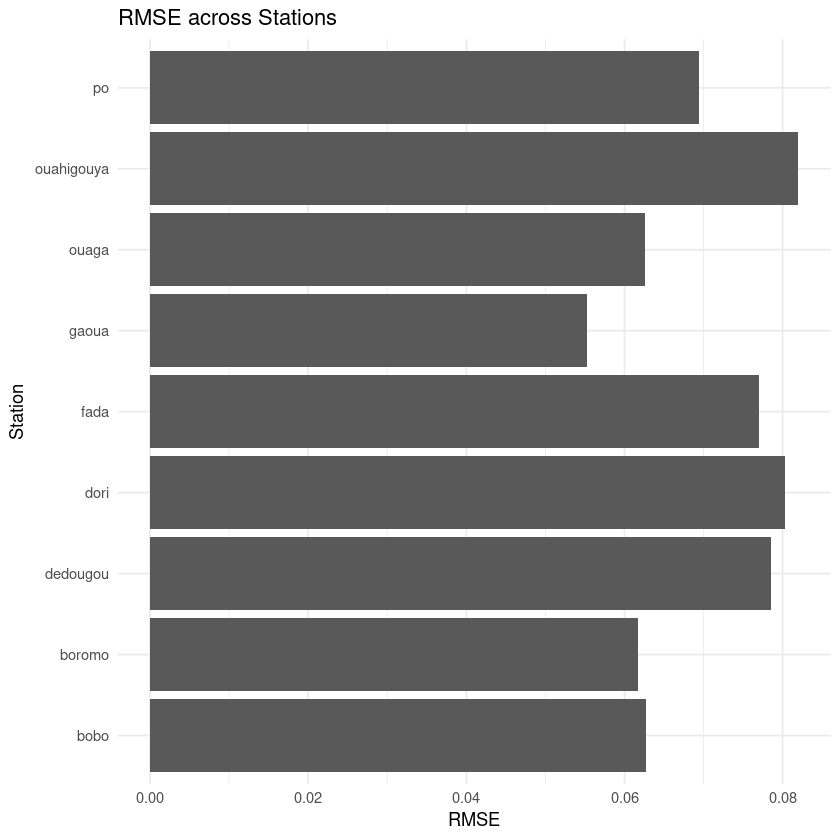

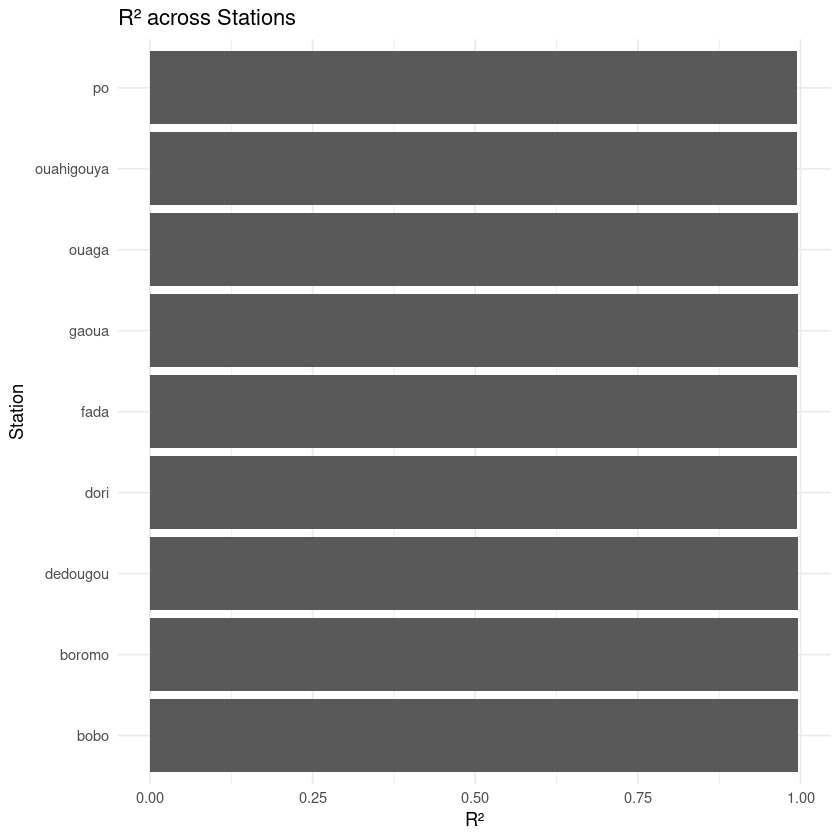

In [10]:
stations_names <- unique(stations_data$stations)  # Définir les noms des stations
performance_metrics <- data.frame()  # Initialiser un dataframe pour les métriques de performance

# Boucle sur chaque station
i <- 0
ns <- length(stations_names)

for (station in stations_names) {
  i <- i + 1
  cat("Processing station:", station, " (", i, "/", ns, ")\n")
  
  # Filtrer les données pour la station courante
  station_data <- stations_data %>%
    dplyr::filter(stations == station)
  
  # Division des données en ensembles d'entraînement et de test
  set.seed(123)
  data_split <- initial_split(station_data, prop = 0.8)
  train_data <- training(data_split)
  test_data <- testing(data_split)
  
  # Prétraitement des données
  recipe <- recipe(et0 ~ tx + tn + rh + rs + ws, data = train_data) %>%
    step_normalize(all_predictors())
  
  # Définir le modèle de réseaux de neurones baggés
  bagged_nn_model <- bag_mlp(
    hidden_units = tune(),
    penalty = tune(),
    epochs = tune()
  ) %>%
    set_engine("nnet") %>%
    set_mode("regression")
  
  # Créer le workflow
  bagged_nn_workflow <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(bagged_nn_model)
  
  # Définir la grille de recherche pour les hyperparamètres
  bagged_nn_grid <- grid_regular(
    hidden_units(range = c(1, 10)),
    penalty(range = c(0.01, 0.1)),
    epochs(range = c(50, 200)),
    levels = 5
  )
  
  cat("Grid length:", nrow(bagged_nn_grid), "\n")
  
  # Validation croisée
  cv_folds <- vfold_cv(train_data, v = 5)
  
  # Entraîner et évaluer le modèle
  bagged_nn_fit <- tune_grid(
    bagged_nn_workflow,
    resamples = cv_folds,
    grid = bagged_nn_grid,
    metrics = metric_set(rmse),
    control = control_grid(save_pred = TRUE, parallel_over = "everything")
  )
  
  # Sauvegarder les résultats de la validation croisée
  saveRDS(bagged_nn_fit, file = paste0("cv_results_bagged_nn_", station, ".rds"))
  
  # Sélectionner le meilleur modèle
  best_params <- select_best(bagged_nn_fit, metric = "rmse")
  
  # Finaliser et ajuster le modèle final
  final_bagged_nn <- finalize_workflow(bagged_nn_workflow, best_params)
  bagged_nn_final_model <- fit(final_bagged_nn, data = train_data)
  
  # Faire des prédictions sur l'ensemble de test
  final_predictions <- predict(bagged_nn_final_model, test_data) %>%
    bind_cols(test_data)
  
  # Calculer les métriques de performance
  rmse_value <- rmse(final_predictions, truth = et0, estimate = .pred)
  rsq_value <- rsq(final_predictions, truth = et0, estimate = .pred)
  
  # Sauvegarder les métriques de performance
  performance_metrics <- rbind(performance_metrics, data.frame(
    station = station,
    rmse = rmse_value$.estimate,
    rsq = rsq_value$.estimate
  ))
  
  # Sauvegarder le modèle final dans un fichier RDS
  saveRDS(bagged_nn_final_model, file = paste0("bagged_nn_model_", station, ".rds"))
}

# Visualiser les performances du modèle à travers les stations
ggplot(performance_metrics, aes(x = station, y = rmse)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "RMSE across Stations", x = "Station", y = "RMSE") +
  theme_minimal()

ggplot(performance_metrics, aes(x = station, y = rsq)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "R² across Stations", x = "Station", y = "R²") +
  theme_minimal()
